In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [11]:
X = pd.read_csv("../data/processed/X_all.csv")
y = pd.read_csv("../data/processed/y_all.csv")["TARGET"]
print(f"Shape: X = {X.shape}, y = {y.shape}")


Shape: X = (307507, 251), y = (307507,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (230630, 251), Test size: (76877, 251)


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
from sklearn.linear_model import LogisticRegression

# Remove 'lr' argument (it's invalid for LogisticRegression)
lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='saga',       # or 'saga' for large datasets
)

lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression AUC: 0.7542350622523302
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70671
           1       0.49      0.01      0.02      6206

    accuracy                           0.92     76877
   macro avg       0.71      0.51      0.49     76877
weighted avg       0.89      0.92      0.88     76877



In [7]:
dt = DecisionTreeClassifier(random_state=42, max_depth=7)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

print("Decision Tree AUC:", roc_auc_score(y_test, y_prob_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree AUC: 0.730422367036976
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70671
           1       0.40      0.02      0.04      6206

    accuracy                           0.92     76877
   macro avg       0.66      0.51      0.50     76877
weighted avg       0.88      0.92      0.88     76877



In [8]:
rf = RandomForestClassifier(n_estimators=251, random_state=42, max_depth=15)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest AUC: 0.7490143820174691
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70671
           1       1.00      0.00      0.00      6206

    accuracy                           0.92     76877
   macro avg       0.96      0.50      0.48     76877
weighted avg       0.93      0.92      0.88     76877



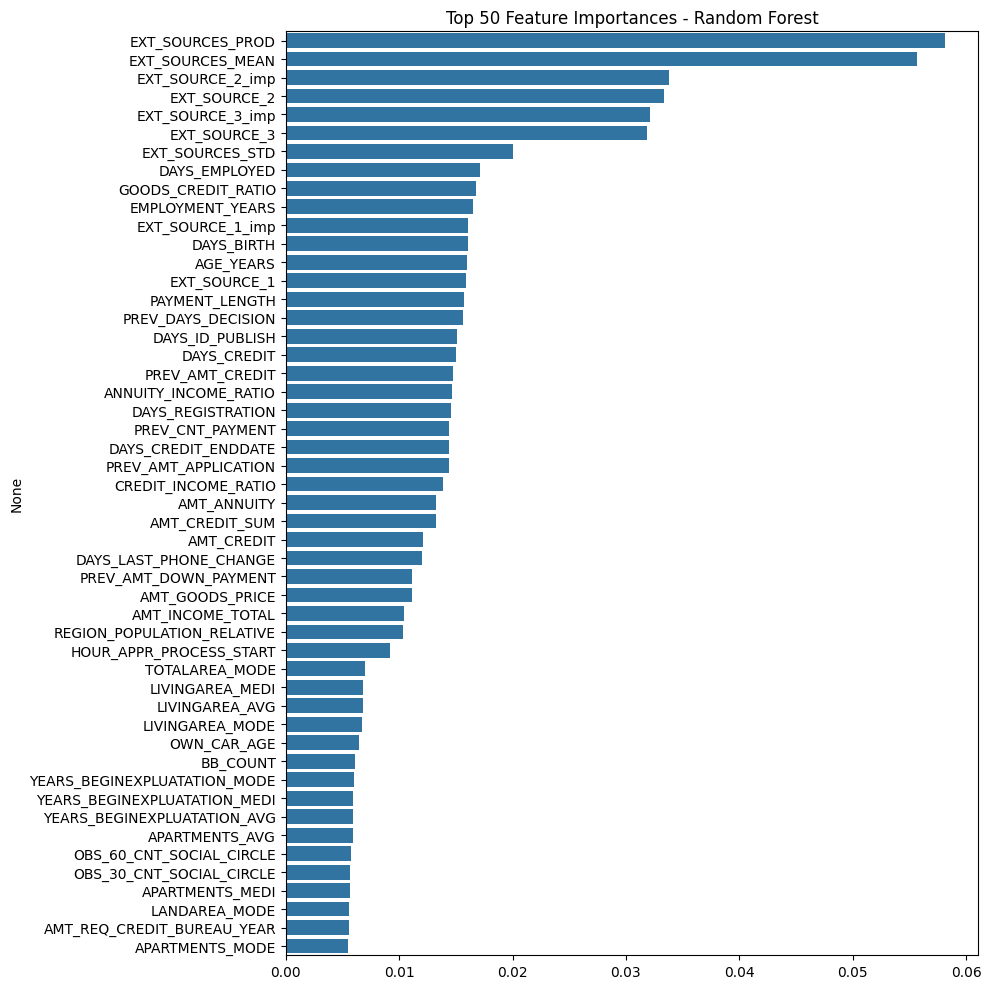

In [52]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(50)

plt.figure(figsize=(10, 10))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 50 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
xgb.fit(X_train, y_train)

y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
print("XGBoost AUC:", roc_auc_score(y_test, y_prob_xgb))


XGBoost AUC: 0.7639211595813298


In [19]:
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)


In [8]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

y_prob_lgb = lgbm.predict_proba(X_test)[:, 1]
print("LightGBM AUC:", roc_auc_score(y_test, y_prob_lgb))


[LightGBM] [Info] Number of positive: 18619, number of negative: 212011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17294
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432456
[LightGBM] [Info] Start training from score -2.432456
LightGBM AUC: 0.7708850431843848


In [20]:


# Identify categoricals
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Align categories using union
for col in categorical_features:
    categories = list(set(X_train[col].dropna().unique()).union(set(X_test[col].dropna().unique())))
    X_train[col] = pd.Categorical(X_train[col], categories=categories)
    X_test[col] = pd.Categorical(X_test[col], categories=categories)

# Fit model
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=2030,
    eval_metric='AUC',
    early_stopping_rounds=200,
    verbose=200
)

cat.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features)


Learning rate set to 0.089287
0:	test: 0.6564522	best: 0.6564522 (0)	total: 70.6ms	remaining: 2m 23s
200:	test: 0.7700306	best: 0.7700352 (199)	total: 9.17s	remaining: 1m 23s
400:	test: 0.7735663	best: 0.7736238 (386)	total: 17.1s	remaining: 1m 9s
600:	test: 0.7746796	best: 0.7748971 (565)	total: 24.4s	remaining: 58.1s
800:	test: 0.7749814	best: 0.7750175 (794)	total: 31.7s	remaining: 48.7s
1000:	test: 0.7757121	best: 0.7757121 (1000)	total: 39.1s	remaining: 40.2s
1200:	test: 0.7757653	best: 0.7757823 (1193)	total: 46.5s	remaining: 32.1s
1400:	test: 0.7757356	best: 0.7758205 (1349)	total: 54.1s	remaining: 24.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7758204532
bestIteration = 1349

Shrink model to first 1350 iterations.


In [21]:
# Get feature importance scores
importances = cat.get_feature_importance()
features = cat.feature_names_

# Create a DataFrame of features and their importances
feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
})

# Sort by importance and select top 50
top_50_features = feat_imp_df.sort_values(by="Importance", ascending=False).head(50)

# Display
print(top_50_features)

                                               Feature  Importance
118                                   EXT_SOURCES_MEAN    7.700682
114                                     PAYMENT_LENGTH    6.089967
120                                   EXT_SOURCES_PROD    4.523977
240                                DAYS_CREDIT_ENDDATE    2.998865
113                                 GOODS_CREDIT_RATIO    2.983477
32                                        EXT_SOURCE_2    2.790270
31                                        EXT_SOURCE_1    2.742736
33                                        EXT_SOURCE_3    2.632074
249                                   PREV_CNT_PAYMENT    2.432417
13                                     DAYS_ID_PUBLISH    2.238222
10                                          DAYS_BIRTH    2.168249
248                                 PREV_DAYS_DECISION    2.135580
239                                        DAYS_CREDIT    1.946942
110                                   EMPLOYMENT_YEARS    1.85

In [23]:
# Clean column names
import re

def clean_column_names(df):
    # Replace any character that's not alphanumeric or underscore
    cleaned_columns = [
        re.sub(r'[^A-Za-z0-9_]', '_', col) for col in df.columns
    ]
    df.columns = cleaned_columns
    return df

# Apply to both train and test
X = clean_column_names(X)


print(X.shape, y.shape)

# Cell 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Cell 5: Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




(307507, 251) (307507,)


In [27]:
from sklearn.ensemble import VotingClassifier

blended = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('lgb', lgbm),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft',  # Use predicted probabilities (good for AUC)
 
)
# Fit
blended.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 18619, number of negative: 212011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17294
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432456
[LightGBM] [Info] Start training from score -2.432456
Learning rate set to 0.054945
0:	total: 188ms	remaining: 6m 21s
200:	total: 10.9s	remaining: 1m 38s
400:	total: 20.6s	remaining: 1m 23s
600:	total: 31s	remaining: 1m 13s
800:	total: 41.9s	remaining: 1m 4s
1000:	total: 52.6s	remaining: 54.1s
1200:	total: 1m 3s	remaining: 43.8s
1400:	total: 1m 12s	remaining: 32.7s
1600:	total: 1m 21s	remaining: 22s
1800:	total: 1m 31s	remaining: 11.6s
2000:	total: 1m 40s	remaining: 1.45s
2029:	total: 1m

,estimators,"[('lr', ...), ('lgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [28]:
from sklearn.metrics import roc_auc_score


# Predict
y_pred_proba = blended.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Blended Model AUC: {auc:.4f}")


Blended Model AUC: 0.7513


In [ ]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(lr, "../models/logistic_model.pkl")
joblib.dump(xgb, "../models/xgboost_model.pkl")
joblib.dump(lgbm, "../models/lightgbm_model.pkl")
joblib.dump(cat, "../models/catboost_model.pkl")
joblib.dump(blended, "../models/blended_model.pkl")
print("✅ All models saved to models/")


✅ All models saved to models/


In [24]:
import joblib
import os

os.makedirs("../models", exist_ok=True)
joblib.dump(X_train.columns.tolist(), "../models/catboost_features.pkl")

['../models/catboost_features.pkl']

In [23]:
joblib.dump(cat, "../models/catboost_model.pkl")

['../models/catboost_model.pkl']